# Deep learning model comparison
This notebook contains the implementation and evaluation of various neural network models with differing paremeters.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

%aimport manual_review_classifier

Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import os
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

from manual_review_classifier.ClassifierPlots import create_reliability_diagram, create_roc_curve, create_feature_importance_plot
from manual_review_classifier.Analysis import determine_feature_importance, print_accuracy_and_classification_report, predict_classes

sns.set_style("white")
sns.set_context('talk')

Using TensorFlow backend.


In [4]:
training_data = pd.read_pickle('../data/training_data.pkl')

In [5]:
training_data.groupby('call').size()

call
a    14589
f     1600
g     4309
s    21156
dtype: int64

## Four class model

In [6]:
# Get Labels
Y = pd.get_dummies(training_data.call).astype(float).values
# Get training data as numpy array
X = training_data.drop('call', axis=1).astype(float).values

In [7]:
X.shape

(41654, 71)

In [8]:
Y.shape

(41654, 4)

In [9]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [10]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(71, input_dim=71, kernel_initializer='normal', activation='tanh'))
    model.add(Dense(20, activation='tanh'))
    model.add(Dense(20, activation='tanh'))
    model.add(Dense(20, activation='tanh'))
    model.add(Dense(20, activation='tanh'))
    model.add(Dense(4, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [11]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=700, batch_size=2000, verbose=0)

In [12]:
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [13]:
if not os.path.exists('../data/deep_learning/multiclass_relu_probs.npy'):
    probabilities = cross_val_predict(estimator, X, Y, cv=kfold, method='predict_proba')
    np.save('../data/deep_learning/multiclass_relu_probs.npy', probabilities)
else:
    probabilities = np.load('../data/deep_learning/multiclass_relu_probs.npy')

#### Classification report key
* 0 = ambiguous
* 1 = fail
* 2 = germline
* 3 = somatic

In [14]:
print_accuracy_and_classification_report(Y, predict_classes(probabilities))

Cross validation accuracy:
	 0.820113314448

Cross validation classification report

             precision    recall  f1-score   support

          0       0.81      0.76      0.79     14589
          1       0.54      0.46      0.49      1600
          2       0.70      0.78      0.74      4309
          3       0.87      0.89      0.88     21156

avg / total       0.82      0.82      0.82     41654



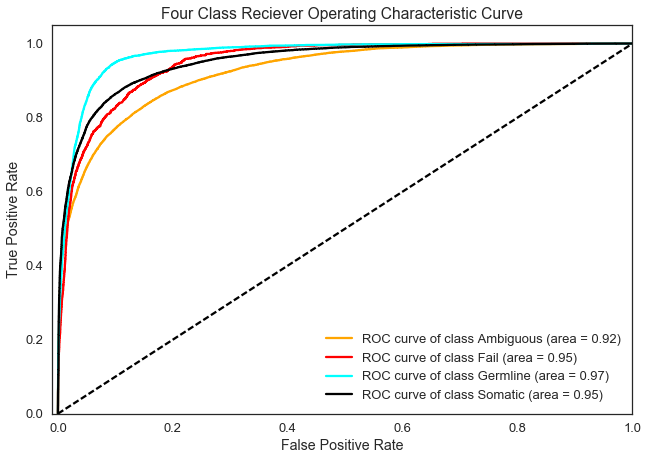

In [15]:
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Germline', 3: 'Somatic'}
create_roc_curve(Y, probabilities, class_lookup, 'Four Class Reciever '
                'Operating Characteristic Curve')

confidence intervals +-:  [ 0.00039082  0.00358407  0.0055062   0.00664793  0.00779148  0.00738297
  0.00793836  0.00665025  0.00504016  0.001231  ]


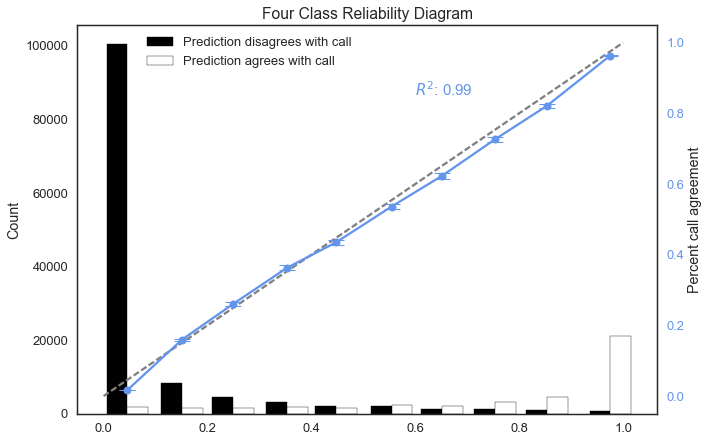

In [16]:
create_reliability_diagram(probabilities, Y, 
                           ['Ambiguous','Fail','Germline', 'Somatic'], 
                           'cornflowerblue', 'Four Class Reliability Diagram')

## Feature importance analysis four class classifier

In [17]:
feature_metrics = determine_feature_importance(estimator, X, Y, False)

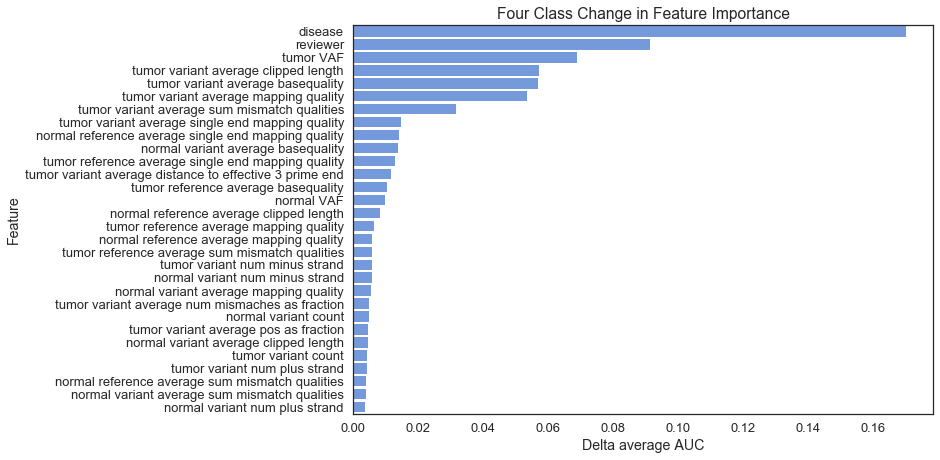

In [18]:
create_feature_importance_plot(feature_metrics, 'Four Class Change in Feature Importance')

## Refactor to single class classifier 
Manual reviewer's calling variants germline is problematic as the callers that produced the calls are designed to call somatic variants. These germline calls are likely very poor quality and in most analysis streams get thrown out anyway. While 'ambigous' variant exist in a grey area where the reviewer is unsure whether to call the variant somatic or fail. All of these classes (germile, ambiguous, and fail) are treated the same in downstream analysis (thrown out). The analyisis imidiately below and subsequent 'three class' analysis allow comparison of model performance by different categorizations of fail.

In [17]:
training_data.groupby('call').size()

call
a    14589
f     1600
g     4309
s    21156
dtype: int64

In [18]:
training_data['binary_call'] = training_data.call.replace(['a', 'f', 'g'], False)
training_data['binary_call'] = training_data['binary_call'].replace('s', True)

In [19]:
training_data.groupby('binary_call').size()

binary_call
False    20498
True     21156
dtype: int64

In [20]:
# Get Labels
binary_Y = training_data.binary_call.astype(int).values
# Get training data as numpy array
X = training_data.drop(['call', 'binary_call'], axis=1).astype(float).values

In [21]:
X.shape

(41654, 71)

In [22]:
binary_Y.shape

(41654,)

In [23]:
# define baseline model
def baseline_binary_model():
    # create model
    model = Sequential()
    model.add(Dense(67, input_dim=71, kernel_initializer='normal', activation='tanh'))
    model.add(Dense(23, activation='tanh'))
    model.add(Dense(23, activation='tanh'))
    model.add(Dense(23, activation='tanh'))
    model.add(Dense(23, activation='tanh'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [24]:
binary_estimator = KerasClassifier(build_fn=baseline_binary_model, epochs=700, batch_size=2000, verbose=0)

In [25]:
if not os.path.exists('../data/deep_learning/binary_tanh_probs.npy'):
    binary_probabilities = cross_val_predict(binary_estimator, X, binary_Y, cv=kfold, method='predict_proba')
    np.save('../data/deep_learning/binary_tanh_probs.npy', binary_probabilities)
else:
    binary_probabilities = np.load('../data/deep_learning/binary_tanh_probs.npy')

In [26]:
predicted = np.array([list(a).index(max(list(a))) for a in list(binary_probabilities)])

In [27]:
print_accuracy_and_classification_report(binary_Y, predicted)

Cross validation accuracy:
	 0.881788063571

Cross validation classification report

             precision    recall  f1-score   support

          0       0.88      0.88      0.88     20498
          1       0.88      0.88      0.88     21156

avg / total       0.88      0.88      0.88     41654



In [28]:
somatic_prob = binary_probabilities[:,1]

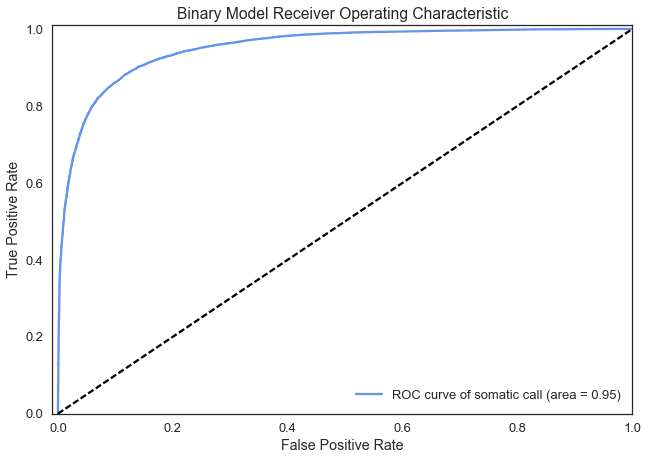

In [29]:
plt.title('Binary Model Receiver Operating Characteristic')
fpr, tpr, _ = metrics.roc_curve(binary_Y, somatic_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='cornflowerblue',label='ROC curve of somatic call'
         ' (area = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

confidence intervals +-:  [ 0.00106546  0.0047849   0.00706929  0.00936436  0.0097725   0.0097725
  0.00936436  0.00706929  0.0047849   0.00106546]


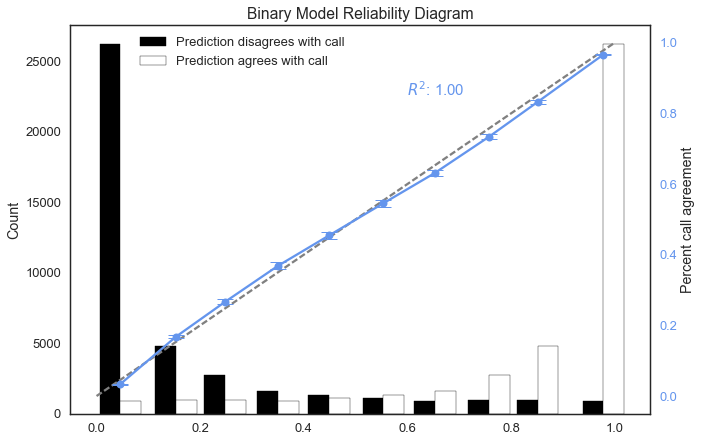

In [30]:
create_reliability_diagram(binary_probabilities, np.array([np.logical_not(binary_Y),binary_Y]).T,['Fail', 'Somatic'], 'cornflowerblue', 'Binary Model Reliability Diagram')

## Feature importance analysis binary classifier

In [33]:
feature_metrics = determine_feature_importance(binary_estimator, X, binary_Y, False)

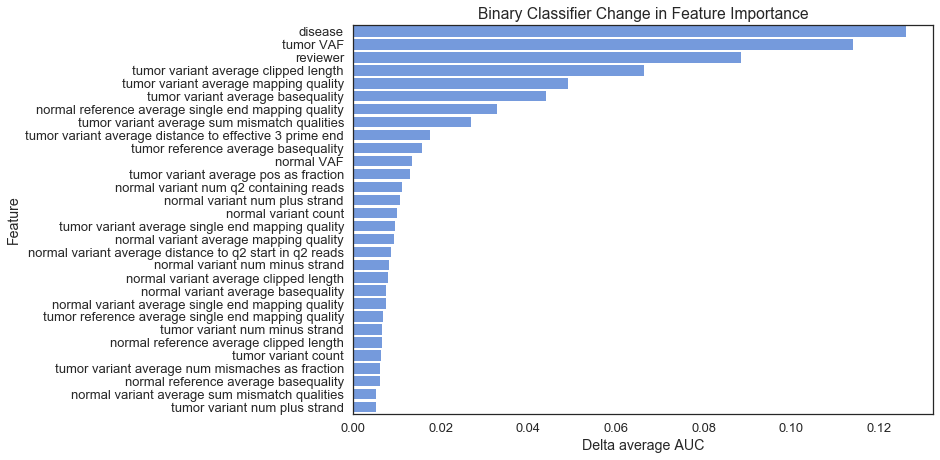

In [34]:
create_feature_importance_plot(feature_metrics, 'Binary Classifier Change in Feature Importance')

# Somatic, ambigous, fail classifier

In [31]:
three_class = training_data.replace('g','f')
three_class.sort_index(axis=1, inplace=True)

In [32]:
three_class.groupby('call').size()

call
a    14589
f     5909
s    21156
dtype: int64

In [33]:
# Get Labels
Y = pd.get_dummies(three_class.call).astype(float).values
# Get training data as numpy array
X = training_data.drop(['call', 'binary_call'], axis=1).astype(float).values

In [34]:
X.shape

(41654, 71)

In [35]:
Y.shape

(41654, 3)

In [36]:
# define baseline model
def three_class_model():
    # create model
    model = Sequential()
    model.add(Dense(71, input_dim=71, kernel_initializer='normal', activation='tanh'))
    model.add(Dense(20, activation='tanh'))
    model.add(Dense(20, activation='tanh'))
    model.add(Dense(20, activation='tanh'))
    model.add(Dense(20, activation='tanh'))
    model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [37]:
estimator = KerasClassifier(build_fn=three_class_model, epochs=700, batch_size=2000, verbose=0)

In [38]:
if not os.path.exists('../data/deep_learning/threeclass_tanh_probs.npy'):
    probabilities = cross_val_predict(estimator, X, Y, cv=kfold, method='predict_proba')
    np.save('../data/deep_learning/threeclass_tanh_probs.npy', probabilities)
else:
    probabilities = np.load('../data/deep_learning/threeclass_tanh_probs.npy')

In [39]:
predicted = np.array([list(a).index(max(list(a))) for a in list(probabilities)])

In [40]:
label_binarizer = preprocessing.LabelBinarizer()

label_binarizer.fit(range(max(predicted)+1))
predicted_transformed = label_binarizer.transform(predicted)

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = somatic

In [41]:
print_accuracy_and_classification_report(Y, predicted_transformed)

Cross validation accuracy:
	 0.830628511067

Cross validation classification report

             precision    recall  f1-score   support

          0       0.81      0.76      0.79     14589
          1       0.71      0.78      0.75      5909
          2       0.88      0.89      0.88     21156

avg / total       0.83      0.83      0.83     41654



### The three class classifier is the most preferable
There appears to be no apparent performance difference between the binary and three class classifier as they both 
predict somatic variants with a ROC AUC of 0.95. However, the three class classifier adds value by outlineing the types of failure.

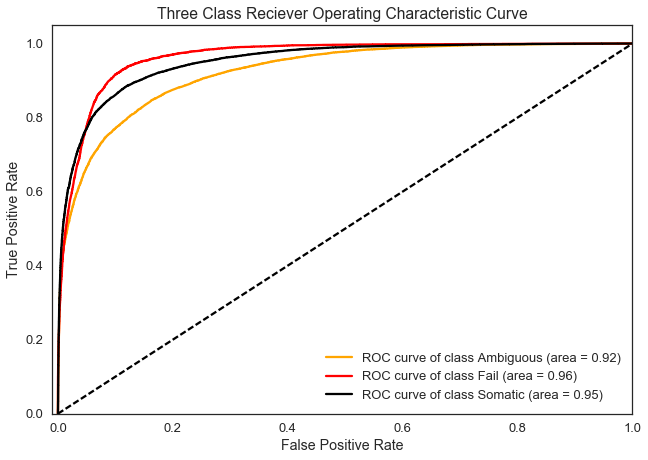

In [42]:
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
create_roc_curve(Y, probabilities, class_lookup, 'Three Class Reciever '
                'Operating Characteristic Curve')

confidence intervals +-:  [ 0.00058744  0.00380737  0.00546475  0.00696819  0.00805465  0.00795595
  0.00745662  0.00643278  0.00499972  0.00123251]


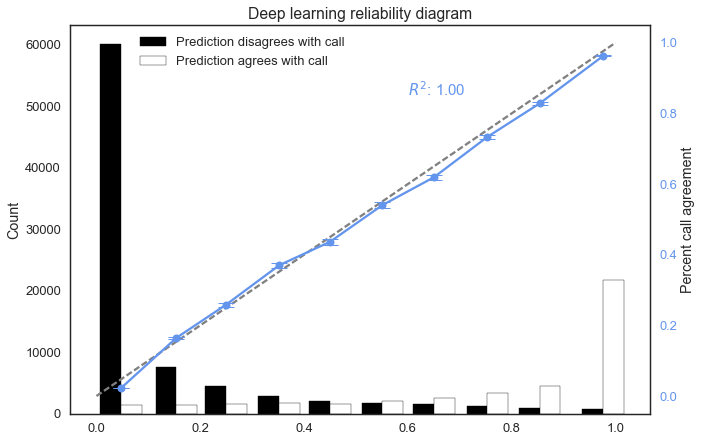

In [43]:
create_reliability_diagram(probabilities, Y,['Ambiguous','Fail','Somatic'], 'cornflowerblue', 'Deep learning reliability diagram')

### Examine reliability per class call

confidence intervals +-:  [ 0.00140411  0.00520256  0.00767536  0.00984627  0.01219225  0.01406989
  0.01171347  0.00902882  0.01019125  0.00227353]


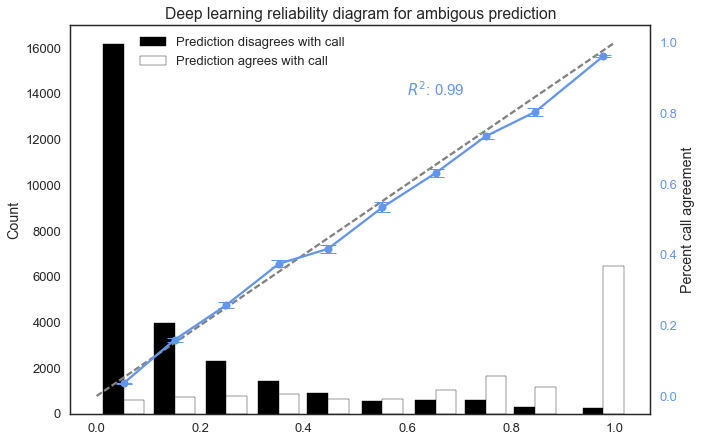

In [44]:
create_reliability_diagram(probabilities[:,:1], Y[:,:1],['Ambiguous'], 'cornflowerblue', 'Deep learning reliability diagram for ambigous prediction')

confidence intervals +-:  [ 0.00058841  0.00942576  0.01442448  0.01965977  0.01566667  0.01436896
  0.01358052  0.01757587  0.01294673  0.00575839]


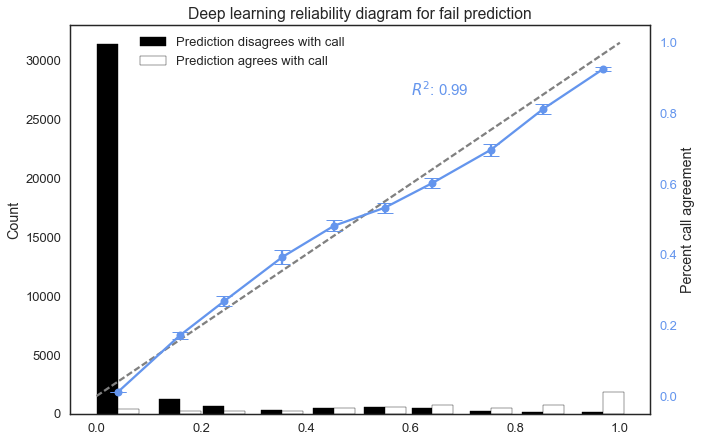

In [45]:
create_reliability_diagram(probabilities[:,1:2], Y[:,1:2],['Fail'], 'cornflowerblue', 'Deep learning reliability diagram for fail prediction')

confidence intervals +-:  [ 0.00153213  0.00692529  0.00924032  0.01138886  0.01464485  0.01300901
  0.01375192  0.01070756  0.00635234  0.00145467]


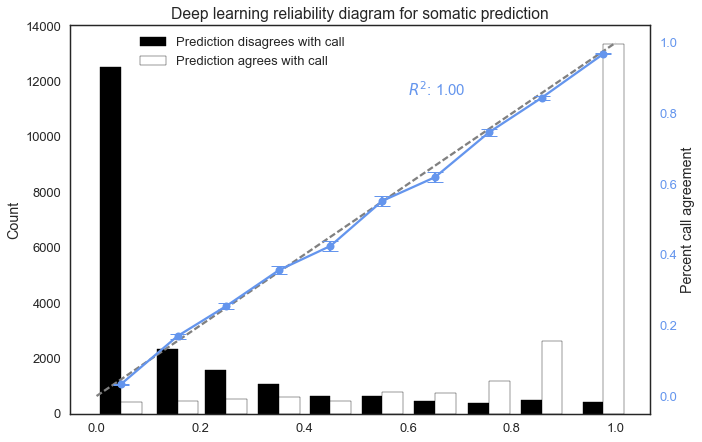

In [46]:
create_reliability_diagram(probabilities[:,2:3], Y[:,2:3],['Somatic'], 'cornflowerblue', 'Deep learning reliability diagram for somatic prediction')

## Feature importance analysis for three class classifier

In [51]:
feature_metrics = determine_feature_importance(estimator, X, Y, False)

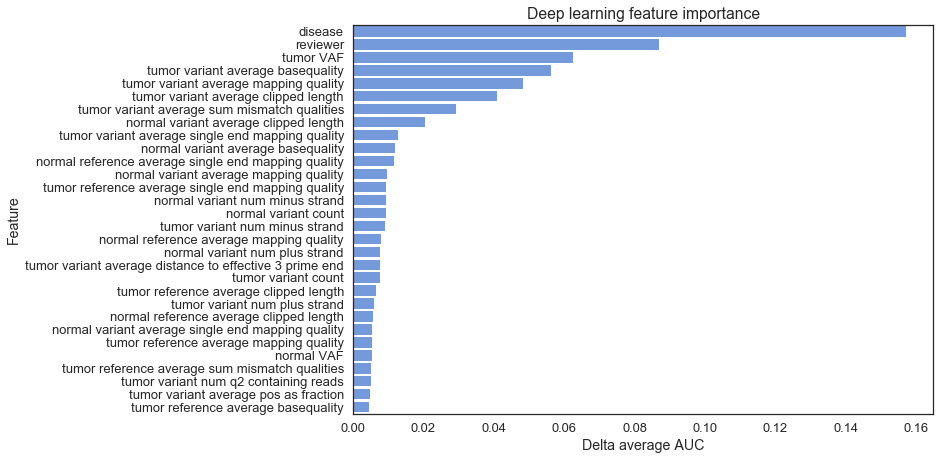

In [52]:
create_feature_importance_plot(feature_metrics, 'Deep learning feature importance')

# Hold out test set analysis
The above cross validation comparisons primary purpose was to determine the classes to include in the classifier and the effect of reviewer on the model. The following analysis will determine the overal performance of the model via cross validation and a hold out test set asuming no reviewer information is provided.

In [47]:
three_class = training_data.replace('g','f')

In [48]:
three_class.groupby('call').size()

call
a    14589
f     5909
s    21156
dtype: int64

In [49]:
# Get Labels
Y = pd.get_dummies(three_class.call).astype(float).values
# Get training data as numpy array, drop reviewer and call
X = three_class.drop(three_class.columns[10:13].tolist() + ['call', 'binary_call'], axis=1).astype(float).values

In [50]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [51]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.33, random_state=seed)

In [52]:
X_train.shape

(27908, 68)

In [53]:
Y_train.shape

(27908, 3)

In [54]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(68, input_dim=68, kernel_initializer='normal', activation='tanh'))
    model.add(Dense(20, activation='tanh'))
    model.add(Dense(20, activation='tanh'))
    model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [55]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=700, batch_size=2000, verbose=0)

In [56]:
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [57]:
if not os.path.exists('../data/deep_learning/threeclass_tanh_test_noreviewer_probs.npy'):
    probabilities = cross_val_predict(estimator, X_train, Y_train, cv=kfold, method='predict_proba')
    np.save('../data/deep_learning/threeclass_tanh_test_noreviewer_probs.npy', probabilities)
else:
    probabilities = np.load('../data/deep_learning/threeclass_tanh_test_noreviewer_probs.npy')

In [58]:
predicted = np.array([list(a).index(max(list(a))) for a in list(probabilities)])

In [59]:
label_binarizer = preprocessing.LabelBinarizer()

label_binarizer.fit(range(max(predicted)+1))
predicted_transformed = label_binarizer.transform(predicted)

In [60]:
metrics.accuracy_score(Y_train, predicted_transformed)

0.8139959868138168

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = somatic

In [61]:
print_accuracy_and_classification_report(Y_train, predicted_transformed)

Cross validation accuracy:
	 0.813995986814

Cross validation classification report

             precision    recall  f1-score   support

          0       0.80      0.75      0.78      9882
          1       0.66      0.78      0.71      3968
          2       0.87      0.87      0.87     14058

avg / total       0.82      0.81      0.81     27908



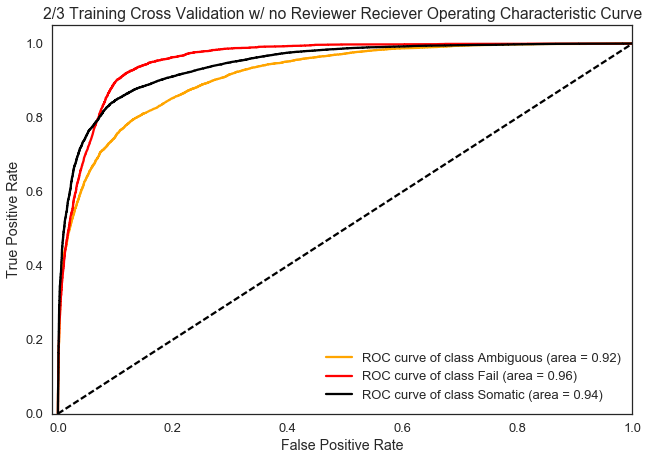

In [62]:
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
create_roc_curve(Y_train, probabilities, class_lookup, '2/3 Training Cross '
                 'Validation w/ no Reviewer Reciever Operating '
                 'Characteristic Curve')

confidence intervals +-:  [ 0.00076224  0.00480291  0.00637777  0.00737085  0.00860215  0.01059822
  0.00951246  0.0081652   0.00608496  0.00159207]


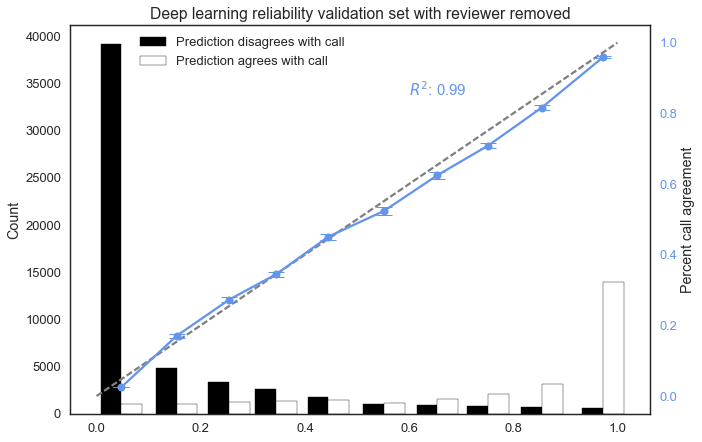

In [63]:
create_reliability_diagram(probabilities, Y_train,['Ambiguous','Fail','Somatic'], 'cornflowerblue', 'Deep learning reliability validation set with reviewer removed')

## Feature importance analysis 2/3 training set w/ no reviewer

In [70]:
feature_metrics = determine_feature_importance(estimator, X_test, Y_test, True)

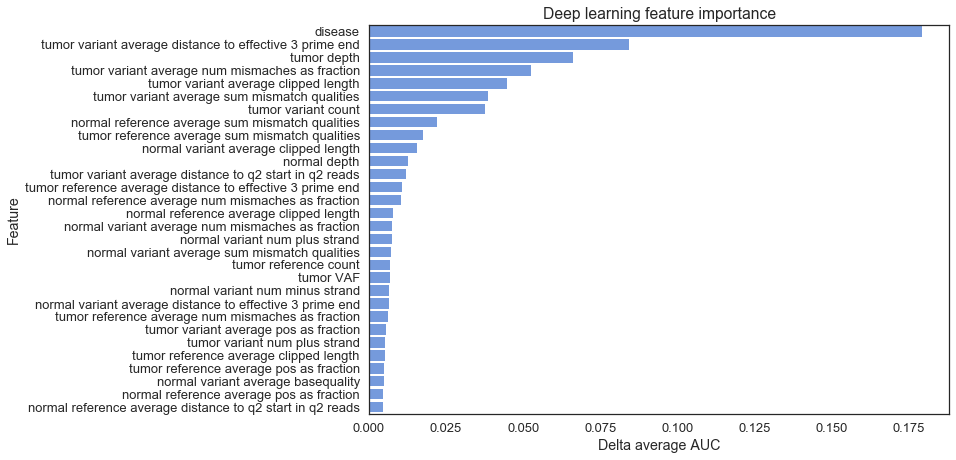

In [71]:
create_feature_importance_plot(feature_metrics, 'Deep learning feature importance')

In [65]:
estimator.fit(X_train, Y_train)

In [67]:
test_probs = estimator.predict_proba(X_test)

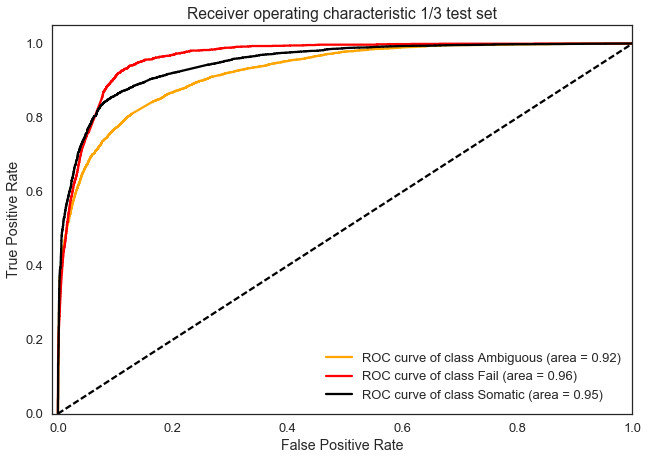

In [68]:
create_roc_curve(Y_test, test_probs, class_lookup, 'Receiver operating'
                 ' characteristic 1/3 test set')

confidence intervals +-:  [ 0.0010493   0.00616301  0.00903418  0.01092714  0.01236759  0.01559388
  0.01370643  0.01033713  0.00847608  0.0021543 ]


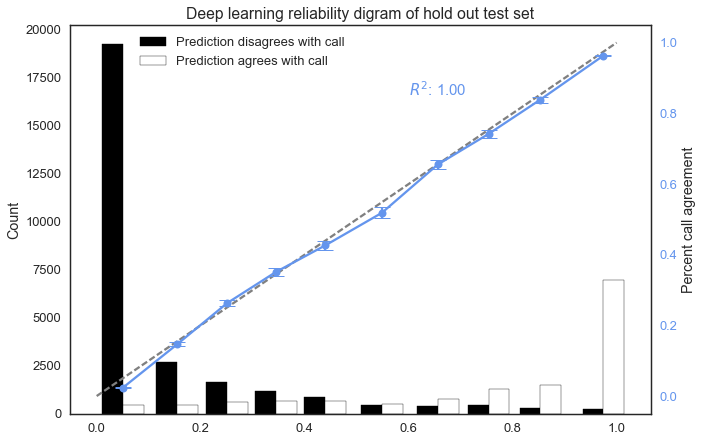

In [69]:
create_reliability_diagram(test_probs, Y_test,['Ambiguous','Fail','Somatic'], 'cornflowerblue', 'Deep learning reliability digram of hold out test set')

# Solid vs blood tumor
Is the importance of the disease feature in the above results correspond to the known tendency for blood cancers to contain tumor cell contamination of the normal sample?

To test this question, all disease columns were recoded into a single binary variable 'solid_tumor', where False is a blood cancer (liquid tumor) and True is a solid tumor. If performance is approximately the same as earlier results, it is likely that the disease feature is based on the difference between solid and liquid tumors.

In [70]:
three_class = training_data.replace('g','f')

In [71]:
s_v_b = three_class
#s_v_b['blood_tumor'] = s_v_b[['disease_AML','disease_lymphoma']].apply(any, axis=1).astype(int)
s_v_b['solid_tumor'] = s_v_b[['disease_GST', 'disease_MPNST', 'disease_SCLC',
                              'disease_breast', 'disease_colorectal', 
                              'disease_glioblastoma', 'disease_melanoma']].apply(any, axis=1).astype(int)
s_v_b.drop(['disease_AML', 'disease_GST', 'disease_MPNST', 'disease_SCLC',
       'disease_breast', 'disease_colorectal', 'disease_glioblastoma',
       'disease_lymphoma', 'disease_melanoma'], axis=1, inplace=True)

In [72]:
s_v_b.groupby('call').size()

call
a    14589
f     5909
s    21156
dtype: int64

In [73]:
# Get Labels
Y = pd.get_dummies(three_class.call).astype(float).values
# Get training data as numpy array
X = s_v_b.drop(['call', 'binary_call'], axis=1).astype(float).values

In [74]:
X.shape

(41654, 63)

In [75]:
Y.shape

(41654, 3)

In [76]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [77]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(63, input_dim=63, kernel_initializer='normal', activation='tanh'))
    model.add(Dense(20, activation='tanh'))
    model.add(Dense(20, activation='tanh'))
    model.add(Dense(20, activation='tanh'))
    model.add(Dense(20, activation='tanh'))
    model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [78]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=700, batch_size=2000, verbose=0)

In [79]:
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [80]:
if not os.path.exists('../data/deep_learning/solid_v_blood_tanh_probs.npy'):
    probabilities = cross_val_predict(estimator, X, Y, cv=kfold, method='predict_proba')
    np.save('../data/deep_learning/solid_v_blood_tanh_probs.npy', probabilities)
else:
    probabilities = np.load('../data/deep_learning/solid_v_blood_tanh_probs.npy')

In [81]:
predicted = np.array([list(a).index(max(list(a))) for a in list(probabilities)])

In [82]:
label_binarizer = preprocessing.LabelBinarizer()

label_binarizer.fit(range(max(predicted)+1))
predicted_transformed = label_binarizer.transform(predicted)

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = somatic

In [83]:
print_accuracy_and_classification_report(Y, predicted_transformed)

Cross validation accuracy:
	 0.827195467422

Cross validation classification report

             precision    recall  f1-score   support

          0       0.81      0.76      0.79     14589
          1       0.71      0.77      0.74      5909
          2       0.88      0.89      0.88     21156

avg / total       0.83      0.83      0.83     41654



### The simplified 'solid tumor' variable maintains performance seen in earlier models
The 'solid tumor' variable adequately replaces listing individual diseases. Using this variable going forward will allow for more types of tumors to be called by this model

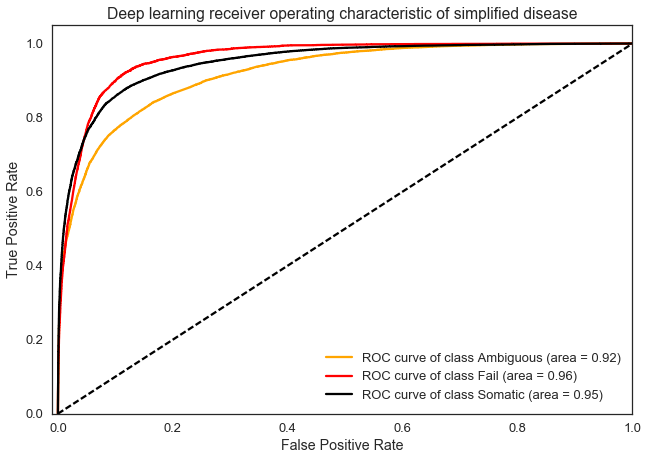

In [84]:
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
create_roc_curve(Y, probabilities, class_lookup, 'Deep learning receiver '
                 'operating characteristic of simplified disease')

confidence intervals +-:  [ 0.00060379  0.00361411  0.0053779   0.00680834  0.00817335  0.007902
  0.00757474  0.00596206  0.00477995  0.0012711 ]


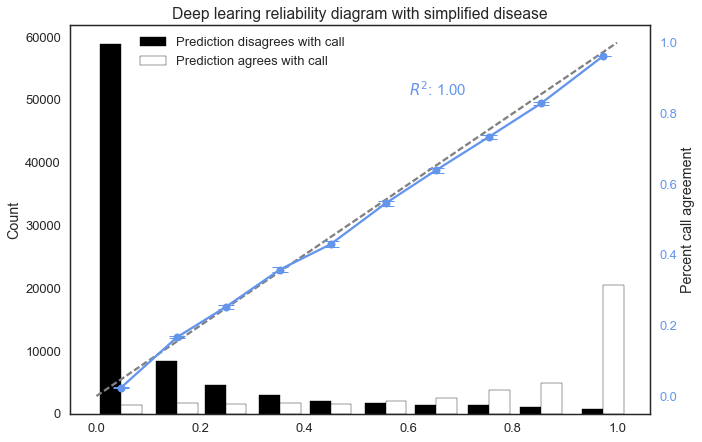

In [85]:
create_reliability_diagram(probabilities, Y,['Ambiguous','Fail','Somatic'], 'cornflowerblue', 'Deep learing reliability diagram with simplified disease')

# Independent test set analysis

## Hodgkin's Lymphoma

In [86]:
# Get Labels
Y = pd.get_dummies(three_class.call).astype(float).values
# Get training data as numpy array
X = s_v_b.sort_index(axis=1).drop(['call', 'binary_call', 'reviewer_Lee',
                'reviewer_Avi', 'reviewer_Heather', 
                'reviewer_Nick'], axis=1).astype(float).values

In [87]:
hodgkins_data = pd.read_pickle('../data/independent_test/hodgkins_lymphoma_train.pkl')
hodgkins_data['solid_tumor'] = 0

In [88]:
hodgkins_call = pd.read_pickle('../data/independent_test/hodgkins_lymphoma_call.pkl')
hodgkins_call=hodgkins_call.map(str.lower).replace('g','f')
hodgkins_call.value_counts()

s    3187
a     240
f      85
Name: call, dtype: int64

In [89]:
# Get Labels
hodgkins_Y = pd.get_dummies(hodgkins_call).astype(float).values
# Get training data as numpy array
hodgkins_X = hodgkins_data.sort_index(axis=1).drop(['disease_lymphoma', 'reviewer_Lee',
                                 'reviewer_FG', 'reviewer_Felicia', 
                                 'reviewer_Zach'], axis=1).astype(float).values

In [90]:
X.shape

(41654, 59)

In [91]:
# define baseline model
def three_class_model():
    # create model
    model = Sequential()
    model.add(Dense(59, input_dim=59, kernel_initializer='normal', activation='tanh'))
    model.add(Dense(20, activation='tanh'))
    model.add(Dense(20, activation='tanh'))
    model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [92]:

estimator = KerasClassifier(build_fn=three_class_model, epochs=700, batch_size=2000, verbose=0)

In [93]:
estimator.fit(X, Y)

In [94]:
hodgkins_probs = estimator.predict_proba(hodgkins_X)

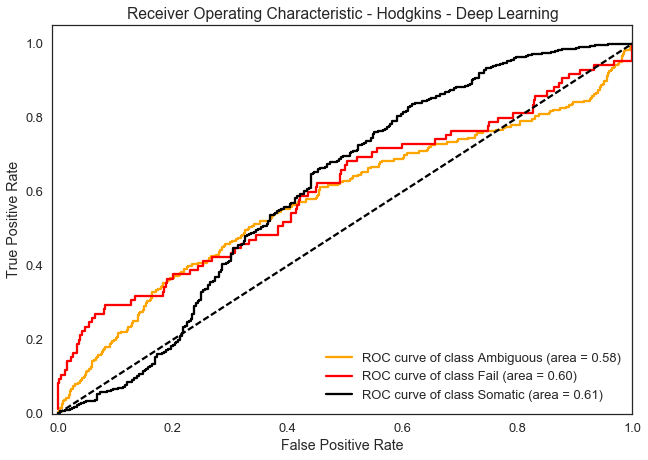

In [95]:
create_roc_curve(hodgkins_Y, hodgkins_probs, class_lookup, 
                 'Receiver Operating Characteristic - Hodgkins - '
                 'Deep Learning')

confidence intervals +-:  [ 0.00326964  0.0146739   0.02402026  0.02805233  0.03192974  0.03191335
  0.03240926  0.0273321   0.01856704  0.00684316]


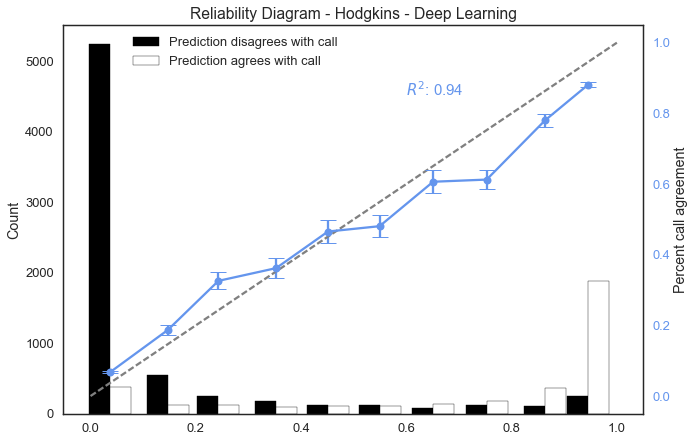

In [96]:
create_reliability_diagram(hodgkins_probs, hodgkins_Y,
                           ['Ambiguous','Fail','Somatic'], 
                           'cornflowerblue', 
                           'Reliability Diagram - Hodgkins - Deep Learning')

## HCC

In [97]:
hcc_data = pd.read_pickle('../data/independent_test/hcc_train.pkl')
hcc_data['solid_tumor'] = 1

In [98]:
hcc_call = pd.read_pickle('../data/independent_test/hcc_call.pkl')
hcc_call=hcc_call.map(str.lower).replace('g','f').replace('s\x03', 's').replace('', 'f')
hcc_call.value_counts()

s    2449
a      33
f      13
Name: call, dtype: int64

In [99]:
# Get Labels
hcc_Y = pd.get_dummies(hcc_call).astype(float).values
# Get training data as numpy array
hcc_X = hcc_data.sort_index(axis=1).drop(['disease_HCC', 'reviewer_Erica', 'reviewer_Erica ',
                                 'reviewer_Jason', 'reviewer_KK', 
                                 'reviewer_Zach'], axis=1).astype(float).values

In [100]:
hcc_probs = estimator.predict_proba(hcc_X)

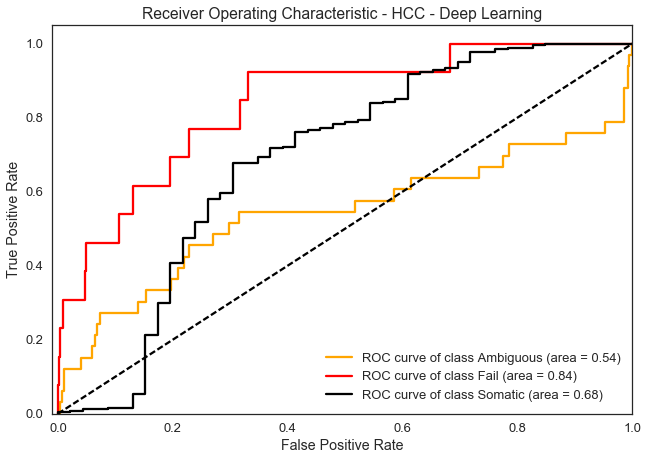

In [101]:
create_roc_curve(hcc_Y, hcc_probs, class_lookup, 
                 'Receiver Operating Characteristic - HCC - Deep Learning')

confidence intervals +-:  [ 0.004148    0.01746284  0.02155726  0.02370518  0.02773041  0.02715421
  0.02424052  0.02212182  0.01813959  0.01504883]


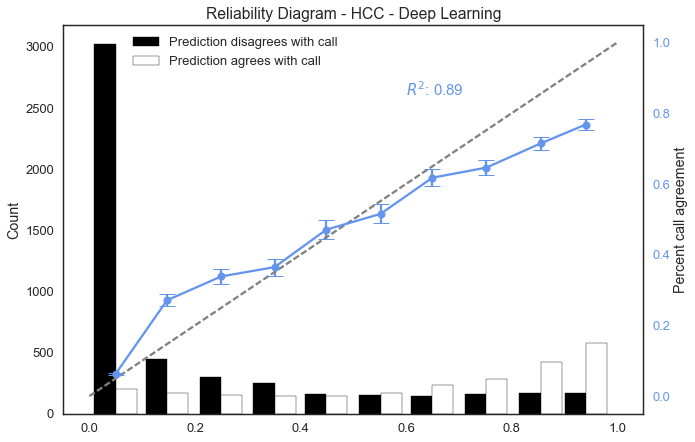

In [102]:
create_reliability_diagram(hcc_probs, hcc_Y,
                           ['Ambiguous','Fail','Somatic'], 
                           'cornflowerblue', 
                           'Reliability Diagram - HCC - Deep Learning')

## TST1 test set performance

In [103]:
tst1_data = pd.read_pickle('../manual_review_classifier/tests/test_data/training_data/train.pkl')
tst1_data['solid_tumor'] = 1
tst1_X = tst1_data.sort_index(axis=1).drop(['disease_BRC', 'reviewer_1'], axis=1).astype(float).values
tst1_calls = pd.read_pickle('../manual_review_classifier/tests/test_data/training_data/call.pkl').replace('g','f')
tst1_Y = pd.get_dummies(tst1_calls).astype(float).values

In [104]:
tst1_calls.value_counts()

s    284
a     92
f     67
Name: call, dtype: int64

In [105]:
tst1_probs = estimator.predict_proba(tst1_X)

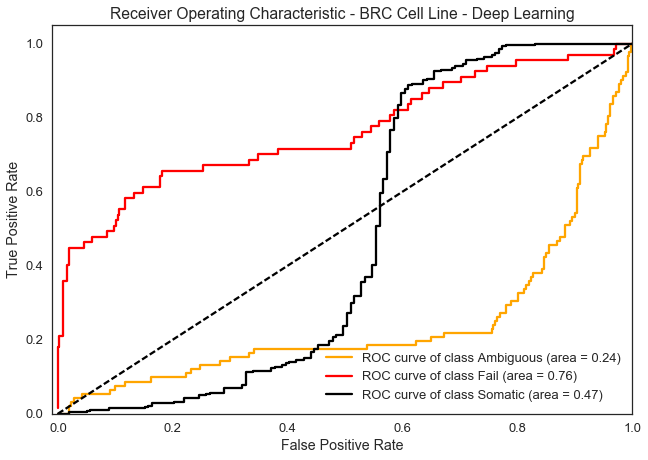

In [106]:
create_roc_curve(tst1_Y, tst1_probs, class_lookup, 
                 'Receiver Operating Characteristic - BRC Cell Line - Deep '
                 'Learning')

confidence intervals +-:  [ 0.01267204  0.04589831  0.09096285  0.12480754  0.12895351  0.11043724
  0.0999953   0.08617864  0.0516356   0.02519378]


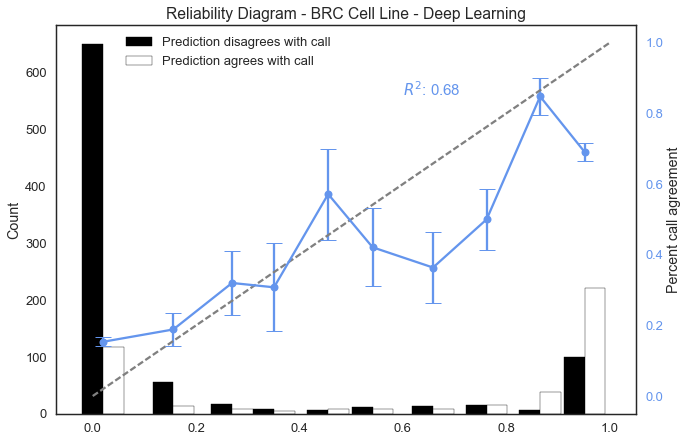

In [113]:
create_reliability_diagram(tst1_probs, tst1_Y,
                           ['Ambiguous','Fail','Somatic'], 
                           'cornflowerblue', 
                           'Reliability Diagram - BRC Cell Line - '
                           'Deep Learning')

## Combine independent test

In [108]:
independent_test_X = np.concatenate([hodgkins_X, hcc_X, tst1_X])
independent_test_Y = np.concatenate([hodgkins_Y, hcc_Y, tst1_Y])

In [109]:
independent_test_probs = estimator.predict_proba(independent_test_X)

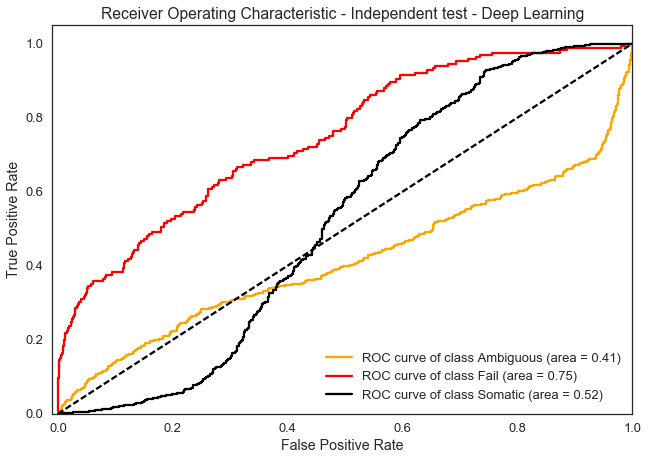

In [110]:
create_roc_curve(independent_test_Y, independent_test_probs, class_lookup, 
                 'Receiver Operating Characteristic - Independent test - '
                 'Deep Learning')

confidence intervals +-:  [ 0.00258292  0.01106217  0.01580201  0.01792213  0.02067731  0.02034773
  0.01914325  0.01690223  0.01271377  0.0063891 ]


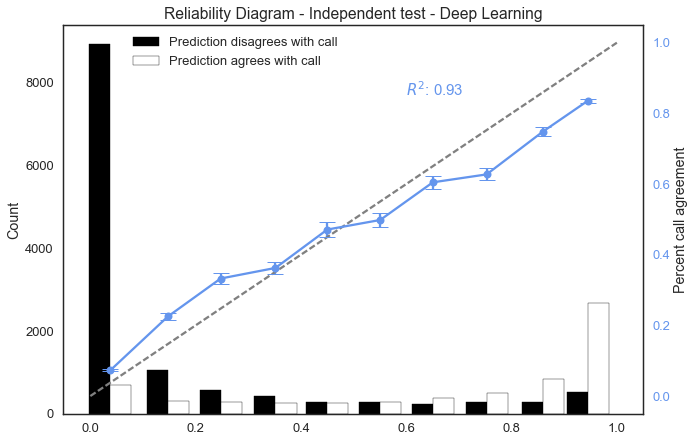

In [112]:
create_reliability_diagram(independent_test_probs, independent_test_Y,
                           ['Ambiguous','Fail','Somatic'], 
                           'cornflowerblue', 
                           'Reliability Diagram - Independent test - '
                           'Deep Learning')

# Encorporate breast cancer cell line test set in training

In [158]:
(tst1_features_train, tst1_features_test, 
 tst1_calls_train, tst1_calls_test) = train_test_split(tst1_X, 
                                                       tst1_Y, 
                                                       test_size=0.5, 
                                                       random_state=seed)

In [159]:
X_tst1 = np.concatenate((X, tst1_features_train))
Y_tst1 = np.concatenate((Y, tst1_calls_train))

In [160]:
if not os.path.exists('../data/deep_learning/threeclass_tst1_tanh_probs.npy'):
    probabilities = cross_val_predict(estimator, X_tst1, Y_tst1, cv=kfold, method='predict_proba')
    np.save('../data/deep_learning/threeclass_tst1_tanh_probs.npy', probabilities)
else:
    probabilities = np.load('../data/deep_learning/threeclass_tst1_tanh_probs.npy')

In [161]:
predicted = np.array([list(a).index(max(list(a))) for a in list(probabilities)])

In [162]:
label_binarizer = preprocessing.LabelBinarizer()

label_binarizer.fit(range(max(predicted)+1))
predicted_transformed = label_binarizer.transform(predicted)

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = somatic

In [163]:
print_accuracy_and_classification_report(Y_tst1, predicted_transformed)

Cross validation accuracy:
	 0.815044776119

Cross validation classification report

             precision    recall  f1-score   support

          0       0.80      0.74      0.77     14632
          1       0.66      0.79      0.72      5945
          2       0.88      0.87      0.87     21298

avg / total       0.82      0.82      0.82     41875



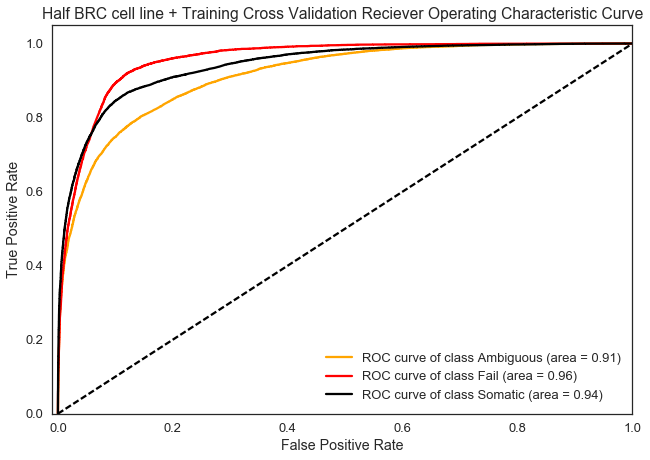

In [164]:
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
create_roc_curve(Y_tst1, probabilities, class_lookup, 
                 'Half BRC cell line + Training Cross Validation Reciever '
                'Operating Characteristic Curve')

confidence intervals +-:  [ 0.00062014  0.00364187  0.00493072  0.00600866  0.00691128  0.00869206
  0.00747387  0.00600087  0.00448426  0.00132219]


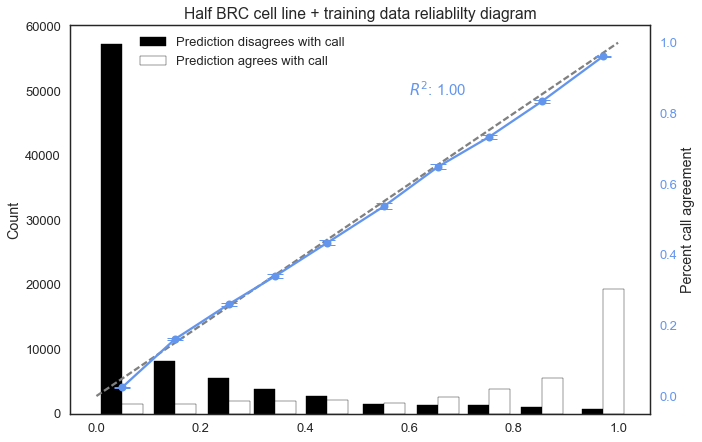

In [165]:
create_reliability_diagram(probabilities, Y_tst1,
                           ['Ambiguous','Fail','Somatic'], 
                           'cornflowerblue','Half BRC cell line + training data reliablilty diagram')

In [166]:
estimator.fit(X_tst1, Y_tst1)

In [167]:
tst1_probs = estimator.predict_proba(tst1_features_test)

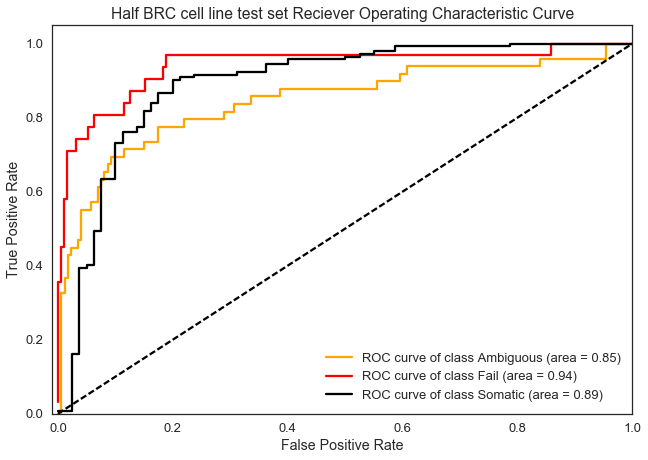

In [168]:
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
create_roc_curve(tst1_calls_test, tst1_probs, class_lookup, 
                 'Half BRC cell line test set Reciever Operating '
                 'Characteristic Curve')

In [ ]:
create_reliability_diagram(tst1_probs, tst1_calls_test,
                           ['Ambiguous','Fail','Somatic'], 
                           'cornflowerblue', 
                           'Reliability Diagram - Half BRC cell line test set')

# Encorporate independent test in training

In [169]:
(independent_test_X_train, independent_test_X_test, 
 independent_test_Y_train, independent_test_Y_test) = train_test_split(independent_test_X, 
                                                       independent_test_Y, 
                                                       test_size=0.5, 
                                                       random_state=seed)

In [170]:
X_half_independent_test = np.concatenate((X, independent_test_X_train))
Y_half_independent_test = np.concatenate((Y, independent_test_Y_train))

In [171]:
if not os.path.exists('../data/deep_learning/threeclass_ind_test_tanh_probs.npy'):
    probabilities = cross_val_predict(estimator, X_half_independent_test, Y_half_independent_test, cv=kfold, method='predict_proba')
    np.save('../data/deep_learning/threeclass_ind_test_tanh_probs.npy', probabilities)
else:
    probabilities = np.load('../data/deep_learning/threeclass_ind_test_tanh_probs.npy')

In [172]:
predicted = np.array([list(a).index(max(list(a))) for a in list(probabilities)])

In [173]:
label_binarizer = preprocessing.LabelBinarizer()

label_binarizer.fit(range(max(predicted)+1))
predicted_transformed = label_binarizer.transform(predicted)

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = somatic

In [174]:
print_accuracy_and_classification_report(Y_half_independent_test, predicted_transformed)

Cross validation accuracy:
	 0.820183159161

Cross validation classification report

             precision    recall  f1-score   support

          0       0.79      0.74      0.77     14760
          1       0.65      0.77      0.71      5999
          2       0.89      0.88      0.88     24120

avg / total       0.82      0.82      0.82     44879



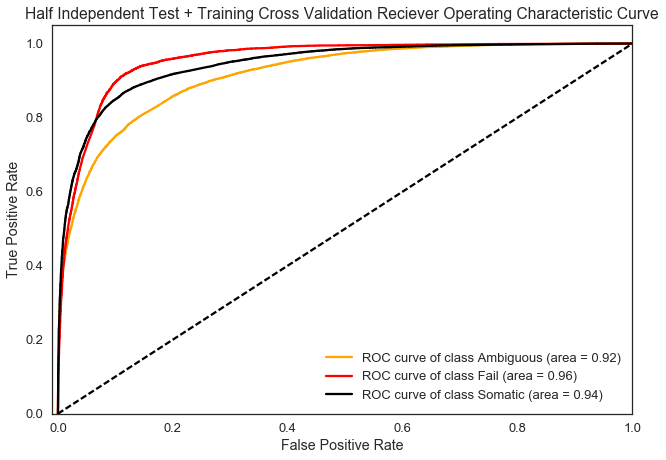

In [175]:
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
create_roc_curve(Y_half_independent_test, probabilities, class_lookup, 
                 'Half Independent Test + Training Cross Validation Reciever '
                'Operating Characteristic Curve')

confidence intervals +-:  [ 0.00058298  0.00348264  0.00477503  0.00605936  0.00674503  0.00848165
  0.00744933  0.00575596  0.00433621  0.00123136]


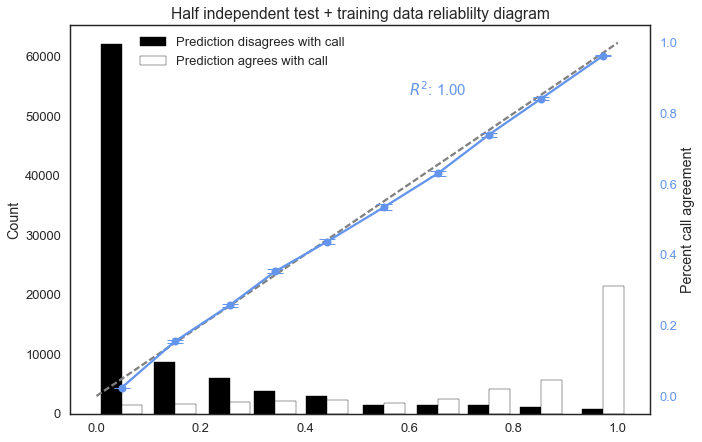

In [176]:
create_reliability_diagram(probabilities, Y_half_independent_test,
                           ['Ambiguous','Fail','Somatic'], 
                           'cornflowerblue','Half independent test + training data reliablilty diagram')

In [177]:
estimator.fit(X_half_independent_test, Y_half_independent_test)

In [178]:
independent_test_X_test_probs = estimator.predict_proba(independent_test_X_test)

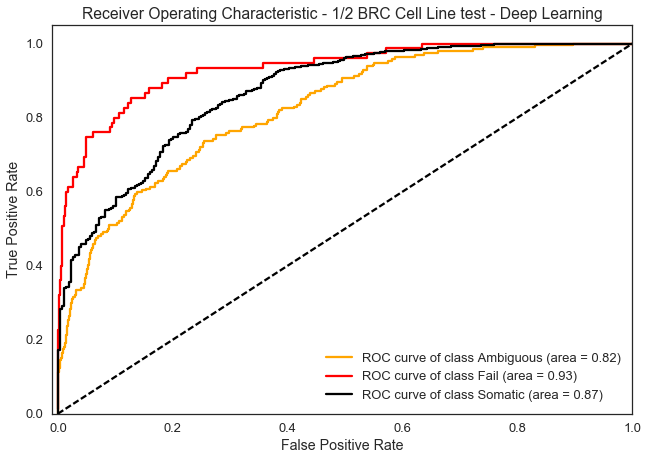

In [179]:
create_roc_curve(independent_test_Y_test, independent_test_X_test_probs, 
                 class_lookup, 'Receiver Operating Characteristic - 1/2 '
                 ' independent test - Deep Learning')

In [ ]:
create_reliability_diagram(independent_test_X_test_probs,
                           independent_test_Y_test,
                           ['Ambiguous','Fail','Somatic'], 
                           'cornflowerblue', 
                           'Reliability Diagram - 1/2 '
                           ' independent test - Deep Learning')